In [1]:
#!pip install pyprojroot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

import sys
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sys.path.append('/content/drive/MyDrive/DataSci207/birdclef/notebooks/')
base_path = '/content/drive/MyDrive/DataSci207/birdclef/'
#import birdclef_raw_data_load

#Load raw data

In [24]:
def load_data():
    """ This method reads in the raw data file and retruns the cleaned raw data"""
    # reading in the data
    #base_path = pyprojroot.find_root(pyprojroot.has_dir("data"))
    data = pd.read_csv((base_path + "data/raw/train.csv"))


    # mapping primary - scientific - common labels
    mapped = data[["primary_label", "scientific_name", "common_name"]]
    mapped = mapped.drop_duplicates()

    #species reference to obtain class label
    spec_dat = pd.read_csv(base_path + "data/raw/taxonomy.csv")
    # taking out the taxon_id since it's duplicated
    spec_dat = spec_dat.drop("inat_taxon_id", axis = 1)

    # merging class_name
    full_data = pd.merge(data, spec_dat, on = ["primary_label", "scientific_name", "common_name"], how = "left")
    full_data.head()


    full_data = full_data.replace(to_replace=r"\[''\]", value=pd.NA, regex=True)


    return full_data

In [25]:
#load raw data
birdclef_df = load_data()
birdclef_df.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,class_name
0,1139490,<NA>,<NA>,1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,Insecta
1,1139490,<NA>,<NA>,1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,Insecta
2,1192948,<NA>,<NA>,1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,Insecta
3,1192948,<NA>,<NA>,1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,Insecta
4,1192948,<NA>,<NA>,1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,Insecta


In [26]:
#birdclef_df = birdclef_raw_data_load.load_data()

species_counts = birdclef_df["primary_label"].value_counts()
print(f"{list(species_counts.index)[0]} Species has highest samples count :  ", max(species_counts) ,
      f"\n{list(species_counts.index)[-1]} Species has lowest samples count : ", min(species_counts))

top_species = list((species_counts[species_counts > 500]).index)
top_species_class = np.unique(list(birdclef_df[birdclef_df["primary_label"].isin(top_species)]["class_name"]))
print("top_species_class", top_species_class)



grekis Species has highest samples count :   990 
64862 Species has lowest samples count :  2
top_species_class ['Aves']


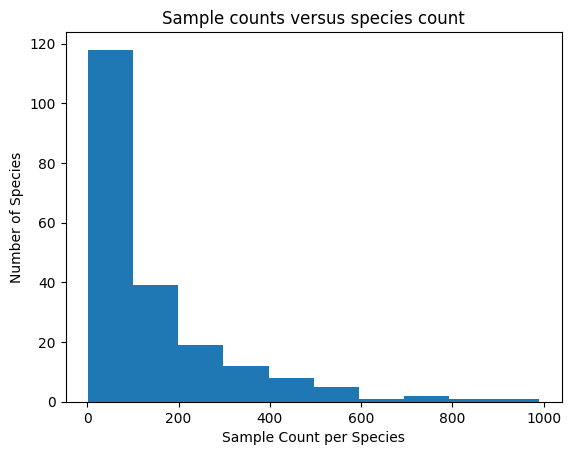

In [27]:
plt.hist(species_counts)
plt.xlabel('Sample Count per Species')
plt.ylabel('Number of Species')
plt.title("Sample counts versus species count")
plt.show()

In [28]:
## Load in spectrogram data and labels
#data=np.load(base_path + 'data/processed/debug_birdclef2025_melspec_5sec_32_32.npy',allow_pickle=True)
#data=np.load(base_path + 'data/processed/birdclef2025_melspec_5sec_256_256.npy',allow_pickle=True)
data=np.load(base_path + 'data/processed/birdclef2025_melspec_5sec_64_64.npy',allow_pickle=True)
graph_dict=data.item()

labels=pd.read_csv(base_path + 'data/raw/taxonomy.csv')
count = len(graph_dict.keys())
print('count', count)
i=0
for key, array in graph_dict.items():
    while i < 5:
        print(f'Key: {key}, Shape: {array.shape}, Dtype: {array.dtype}')
        i += 1

count 28564
Key: 1139490-CSA36385, Shape: (64, 64), Dtype: float32
Key: 1139490-CSA36385, Shape: (64, 64), Dtype: float32
Key: 1139490-CSA36385, Shape: (64, 64), Dtype: float32
Key: 1139490-CSA36385, Shape: (64, 64), Dtype: float32
Key: 1139490-CSA36385, Shape: (64, 64), Dtype: float32


In [29]:
labels[labels['primary_label'] == '1139490']

,primary_label,inat_taxon_id,scientific_name,common_name,class_name
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta


In [30]:
## Create species to keys mapping for visualization
species_to_keys = {}

for key in graph_dict:
    species_name = key.split('-')[0]
    if species_name:
        species_to_keys.setdefault(species_name, []).append(key)


In [31]:
species_to_keys.get('1192948')[0]

'1192948-CSA36358'

## EDA for processed spectrograms

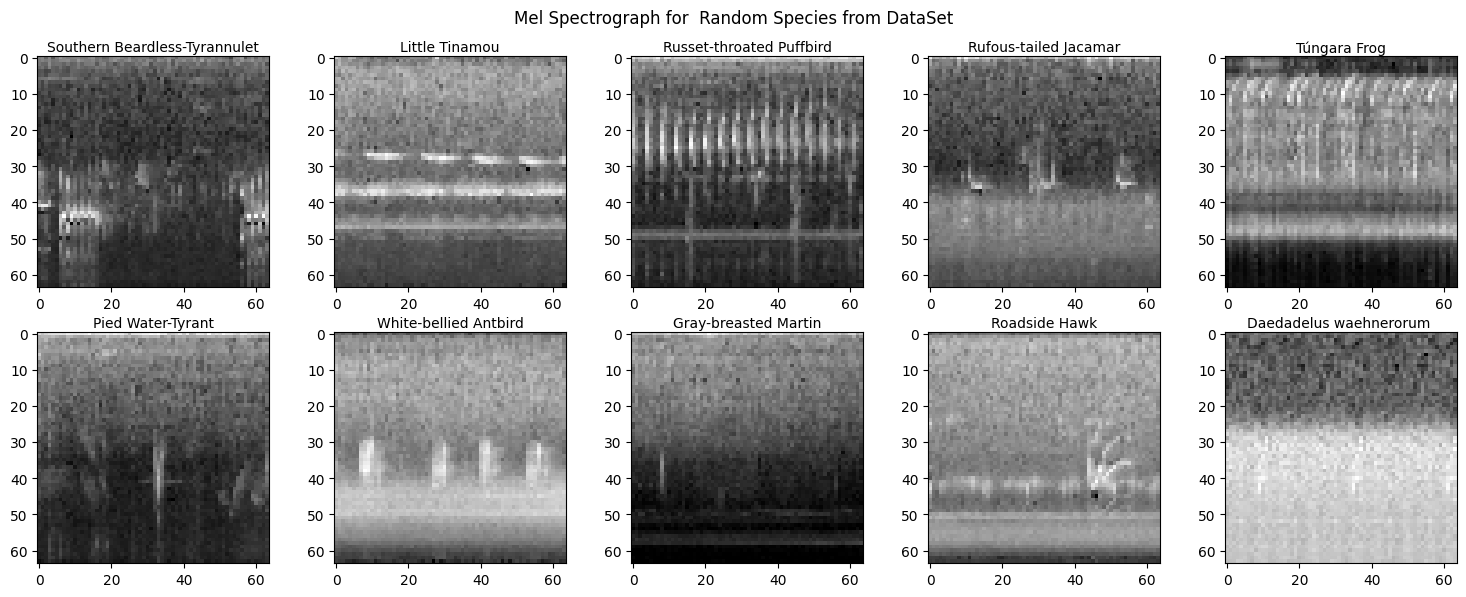

In [32]:

#Print random samples from the data

species_list = list(species_to_keys.keys())
rand_key_list = random.sample(species_list, 10 )

rows = 2
cols = 5
index = 0
fig, axes = plt.subplots(rows,cols, figsize=(cols*3,rows*3))
for row in np.arange(rows):
    for col in np.arange(cols):
        ax = axes[row,col]
        image_key = species_to_keys.get(rand_key_list[index])[0]
        #ax.imshow(graph_dict[image_key],cmap='plasma')
        ax.imshow(graph_dict[image_key], cmap='gray')
        #ax.set_ylabel(image_key, fontsize=8)
        common_name = list(labels[labels["primary_label"] == image_key.split('-')[0]]["common_name"])
        #print("common_name:", common_name)
        ax.set_title(common_name[0], fontsize=10, va='center')
        index += 1
plt.suptitle("Mel Spectrograph for  Random Species from DataSet")
plt.tight_layout()
#plt.subplots_adjust(top=0.9)
plt.show()

Observations: We observe the images for the same species look quite different and images across different species appear to be similar. Appears to be  difficult task to classifiy these images.

## Reading in data and preparing it for ML

In [35]:
## Getting data in label/feature format

X = []
y = []

for key, img in graph_dict.items():
    species = key.split('-')[0]
    if species:
        #Add 1 color channel to grayscale image so we can use with CNN
        img = img.reshape(img.shape + (1,))
        X.append(img)
        y.append(species)

X = np.array(X)
y = np.array(y)

#Encode species labels in y
label_names = labels["primary_label"]
label_encoder = LabelEncoder() # Initialize encoder
y_encoded = label_encoder.fit_transform(y)
#print(y_encoded)
#One hot encode the y label
y_categorical = to_categorical(y_encoded, num_classes = len(np.unique(y_encoded)))
print("y_categorical shape:", y_categorical.shape)
y_categorical



#Set Random Seed
tf.random.set_seed(1234)
np.random.seed(1234)

# shuffle data
rng = np.random.default_rng(seed=1234)
shuffled_indices = rng.permutation(range(y.shape[0]))

# shuffle data #
##################
X = X[shuffled_indices]
y_categorical = y_categorical[shuffled_indices]

# create data splits (training, val, and test sets)
splits = (0.6,0.2,0.2)
splits = np.multiply(len(y), splits).astype(int)
X_train, X_val, X_test = np.split(X, [splits[0], splits[0]+splits[1]])
y_train, y_val, y_test = np.split(y_categorical, [splits[0], splits[0]+splits[1]])


print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


y_categorical shape: (28564, 206)
X_train shape: (17138, 64, 64, 1)
Y_train shape: (17138, 206)
X_val shape: (5712, 64, 64, 1)
y_val shape: (5712, 206)
X_test shape: (5714, 64, 64, 1)
y_test shape: (5714, 206)


## Baseline model for species

In [36]:
#Calculate species with most audio samples in training dataset
species_list = list(species_to_keys.keys())
count_list = []
for species in species_list:
    count_list.append(sum((y == species).astype(int)))
majority_species = species_list[np.argmax(count_list)]
minority_species = species_list[np.argmin(count_list)]
common_name_max = list(labels[labels["primary_label"] == majority_species]["common_name"])
class_name_max = list(labels[labels["primary_label"] == majority_species]["class_name"])
common_name_min = list(labels[labels["primary_label"] == minority_species]["common_name"])
class_name_min = list(labels[labels["primary_label"] == minority_species]["class_name"])

print(f"{common_name_max} Species from class {class_name_max} has highest samples count :  ", max(count_list) ,
      f"\n{common_name_min} Species from class {class_name_min} has lowest samples count : ", min(count_list))


['Great Kiskadee'] Species from class ['Aves'] has highest samples count :   990 
['Ragoniella pulchella'] Species from class ['Insecta'] has lowest samples count :  2


In [37]:
## Creating a baseline model for species classification
y_baseline = (y == majority_species).astype(int)

## Building baseline
num_majority_species = np.sum(y_baseline == 1)
print(f"Number of samples with {majority_species} species : {num_majority_species}")

num_non_majority_species = np.sum(y_baseline== 0)
print(f"Number of samples with non-{majority_species} species: {num_non_majority_species}")

majority_label = 1 if num_majority_species > num_non_majority_species else 0
print(f"Majority label: {majority_label}")

majority_predictions = np.full(y_baseline.shape, majority_label)
accuracy = np.mean(majority_predictions == y_baseline)
print(f"Accuracy of majority label classifier: {accuracy:.4f}")

def log_loss(y_true, y_pred):
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

#Have to make baseline prediction be non zero so log function can work
baseline_pred = np.ones(y_baseline.shape[0])*(majority_label + 0.1 )

train_log_loss = log_loss(y_baseline, baseline_pred)
print(f"Log Loss on training data: {train_log_loss:.4f}")


Number of samples with grekis species : 990
Number of samples with non-grekis species: 27574
Majority label: 0
Accuracy of majority label classifier: 0.9653
Log Loss on training data: 0.1815


We observe that baseline model has very high accuracy due to unbalanced data.

# Species Analysis (Initial)

Simple Baseline CNN model for predicting Species

In [38]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 206)            │     6,750,414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,750,574 (25.75 MB)

 Trainable params: 6,750,574 (25.75 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0243 - loss: 9.2007 - val_accuracy: 0.0338 - val_loss: 4.7811
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0304 - loss: 4.7778 - val_accuracy: 0.0338 - val_loss: 4.7831
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0305 - loss: 4.7786 - val_accuracy: 0.0338 - val_loss: 4.7840
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0307 - loss: 4.7788 - val_accuracy: 0.0338 - val_loss: 4.7845
Epoch 5/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0308 - loss: 4.7790 - val_accuracy: 0.0338 - val_loss: 4.7850
Epoch 6/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0308 - loss: 4.7790 - val_accuracy: 0.0338 - val_loss: 4.7853
Epoch 7/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0309 - loss: 4.7791 - val_accuracy: 0.0338 - val_loss: 4.7857
Epoch 8/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0308 - loss: 4.7791 - val_accur

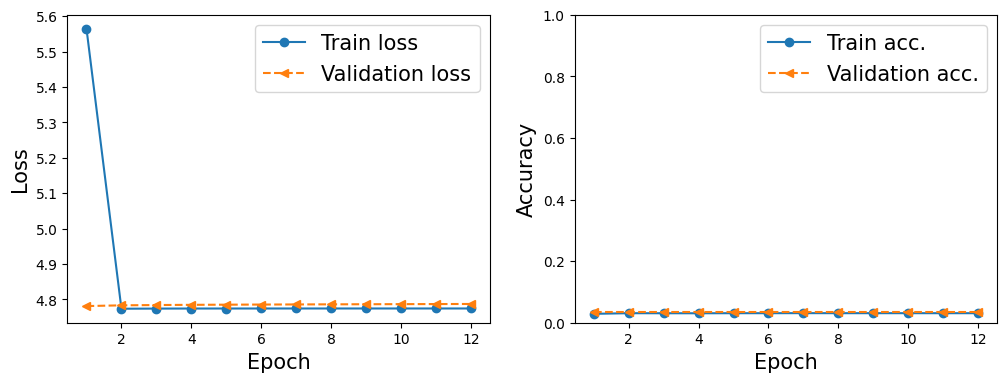

536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0352 - loss: 4.7584

Train Acc. 3.41%
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0300 - loss: 4.7969

Val Acc. 3.38%

Percent Diff in Acc. 1.01%


In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model_tf = tf.keras.Sequential()

# add convolutional layer
model_tf.add(layers.Conv2D(
    #filters=256,
    filters=32,
    kernel_size=(2,2),
    strides=(1,1),
    padding='same',
    data_format="channels_last",
    name='conv_1',
    activation='relu'))



# add max pooling layer
### YOUR CODE HERE ###
model_tf.add(layers.MaxPooling2D((2,2)))

# add dropout layer
### YOUR CODE HERE ###
model_tf.add(layers.Dropout(rate=0.5))

# add a flattening layer
### YOUR CODE HERE ###
model_tf.add(layers.Flatten())

# add the classification layer
### YOUR CODE HERE ###
model_tf.add(layers.Dense(y_train.shape[1], activation='softmax'

))

# build and compile model
#model_tf.build(input_shape=(None, 256,256,1))
model_tf.build(input_shape=(None, X_train.shape[1],X_train.shape[1],1))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# print model_tf summary
### YOUR CODE HERE ###
print(model_tf.summary())

# train model_tf on (X_train, y_train) data
### YOUR CODE HERE ###
history = model_tf.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    epochs=20)

# plot loss curves
### YOUR CODE HERE ###
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
### YOUR CODE HERE ###
train_results = model_tf.evaluate(X_train, y_train)
print('\nTrain Acc. {:.2f}%'.format(train_results[1]*100))

val_results = model_tf.evaluate(X_val, y_val)
print('\nVal Acc. {:.2f}%'.format(val_results[1]*100))

percent_diff = 100*(train_results[1] - val_results[1])/train_results[1]
print('\nPercent Diff in Acc. {:.2f}%'.format(percent_diff))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 206)            │       843,982 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 846,206 (3.23 MB)

 Trainable params: 846,206 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.0281 - loss: 5.7391 - val_accuracy: 0.0338 - val_loss: 4.7811
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0308 - loss: 4.7780 - val_accuracy: 0.0338 - val_loss: 4.7830
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0308 - loss: 4.7787 - val_accuracy: 0.0338 - val_loss: 4.7840
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0308 - loss: 4.7789 - val_accuracy: 0.0338 - val_loss: 4.7846
Epoch 5/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0308 - loss: 4.7790 - val_accuracy: 0.0338 - val_loss: 4.7850
Epoch 6/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0308 - loss: 4.7790 - val_accuracy: 0.0338 - val_loss: 4.7854
Epoch 7/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0308 - loss: 4.7791 - val_accuracy: 0.0338 - val_loss: 4.7857
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


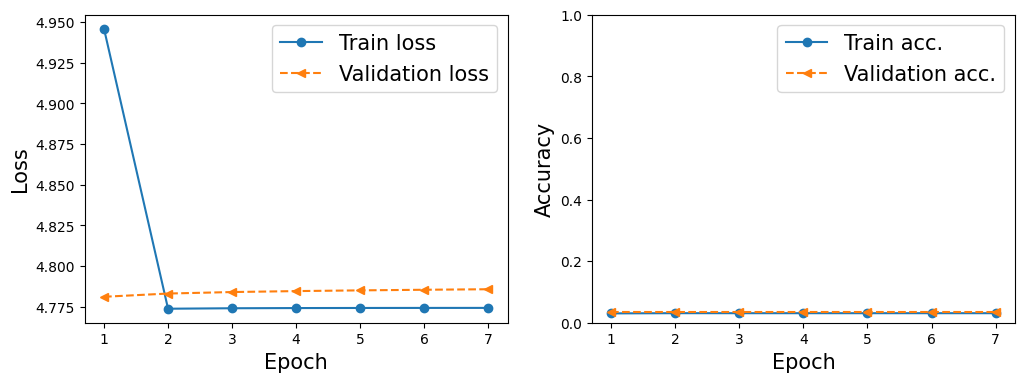

536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0352 - loss: 4.7581

Train Acc. 3.41%
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0300 - loss: 4.7941

Val Acc. 3.38%

Percent Diff in Acc. 1.01%


In [40]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234)
np.random.seed(1234)


# initialize model
model_tf = tf.keras.Sequential()

# add convolutional layer
model_tf.add(layers.Conv2D(
    #filters=256,
    filters=X_train.shape[1],
    kernel_size=(2,2),
    strides=(1,1),
    padding='same',
    data_format="channels_last",
    name='conv_1',
    activation='relu'))



# add max pooling layer
### YOUR CODE HERE ###
model_tf.add(layers.MaxPooling2D((2,2)))

# add dropout layer
### YOUR CODE HERE ###
model_tf.add(layers.Dropout(rate=0.5))


# add 2nd convolutional layer
model_tf.add(layers.Conv2D(
    filters=X_train.shape[1]/2,
    kernel_size=(2,2),
    strides=(1,1),
    padding='same',
    data_format="channels_last",
    name='conv_2',
    activation='relu'))



# add 2nd max pooling layer
### YOUR CODE HERE ###
model_tf.add(layers.MaxPooling2D((2,2)))

# add 2nd dropout layer
### YOUR CODE HERE ###
model_tf.add(layers.Dropout(rate=0.5))

# add a flattening layer
### YOUR CODE HERE ###
model_tf.add(layers.Flatten())

# add the classification layer
### YOUR CODE HERE ###
model_tf.add(layers.Dense(y_train.shape[1], activation='softmax'

))

# build and compile model
model_tf.build(input_shape=(None, X_train.shape[1],X_train.shape[1],1))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# print model_tf summary
### YOUR CODE HERE ###
print(model_tf.summary())

# train model_tf on (X_train, y_train) data
### YOUR CODE HERE ###
history = model_tf.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    epochs=20)

# plot loss curves
### YOUR CODE HERE ###
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
### YOUR CODE HERE ###
train_results = model_tf.evaluate(X_train, y_train)
print('\nTrain Acc. {:.2f}%'.format(train_results[1]*100))

val_results = model_tf.evaluate(X_val, y_val)
print('\nVal Acc. {:.2f}%'.format(val_results[1]*100))

percent_diff = 100*(train_results[1] - val_results[1])/train_results[1]
print('\nPercent Diff in Acc. {:.2f}%'.format(percent_diff))

The simple baseline model has very low accuracy. Need to add additional hidden layers.
Hyperparameter tuning plan:


|Model|# Conv|Filters|Stride|MaxPool|Dropout|L.R.|Optimizer|Train Acc.|Val Acc.|% Diff|
|-|-|-|-|-|-|-|-|-|-|-|
|Baseline|1|256|(2,2)|(4,4)|0.5|0.1|Adam||||
|1|2|(256,128)|(2,2)|(4,4)|0.5|0.1|Adam||||
|2|3|(256,128,64)|(2,2)|(4,4)|0.5|0.1|Adam||||
|3|4|(256,128,64,32)|(2,2)|(4,4)|0.5|0.1|Adam||||
|4|5|(256,128,64,32,16)|(2,2)|(4,4)|0.5|0.1|Adam||||
|5|5|(256,128,64,32,16)|(3,3)|(4,4)|0.5|0.1|Adam||||
|6|5|(256,128,64,32,16)|(4,4)|(4,4)|0.5|0.1|Adam||||
|7|5|(256,128,64,32,16)|(4,4)|(8,8)|0.5|0.1|Adam||||
|8|5|(256,128,64,32,16)|(4,4)|(8,8)|0.4|0.1|Adam||||
|9|5|(256,128,64,32,16)|(4,4)|(8,8)|0.3|0.1|Adam||||
|10|5|(256,128,64,32,16)|(4,4)|(8,8)|0.3|0.01|Adam||||
|11|5|(256,128,64,32,16)|(4,4)|(8,8)|0.3|0.001|Adam||||
|12|5|(256,128,64,32,16)|(4,4)|(8,8)|0.3|0.001|Adamax||||
|13|5|(256,128,64,32,16)|(4,4)|(8,8)|0.3|0.001|SGD||||
|14|5|(256,128,64,32,16)|(4,4)|(8,8)|0.3|0.001|RMSProp||||
|15|5|(256,128,64,32,16)|(4,4)|(8,8)|0.3|0.001|Adagrad||||
|16|5|(256,128,64,32,16)|(4,4)|(8,8)|0.3|0.001|Adadelta||||

# Class Classification

## Data Prep for class classification

In [4]:
# Load common data splits used by entire team
class_names = {0: 'Amphibia' , 1: 'Aves', 2: 'Insecta', 3: 'Mammalia'}

train_data = pd.read_csv((base_path + "data/processed/splits/train_64_64.csv"), delimiter=',', dtype='float')
val_data = pd.read_csv((base_path + "data/processed/splits/val_64_64.csv"), delimiter=',', dtype='float')
test_data = pd.read_csv((base_path + "data/processed/splits/test_64_64.csv"), delimiter=',', dtype='float')

In [41]:
#Convert float labels to int
train_data['labels'] = train_data['labels'].astype(int)
val_data['labels'] = val_data['labels'].astype(int)
test_data['labels'] = test_data['labels'].astype(int)

In [42]:
train_data.shape

(17138, 4097)

In [43]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,labels
0,1.141826,0.922215,1.190636,1.077392,0.992777,0.906169,0.766830,1.097194,1.275572,0.848226,...,0.291499,0.286815,0.228333,0.164706,0.418058,0.442583,0.298470,0.232667,0.133803,1
1,0.403132,0.288625,0.229204,0.384361,0.523661,0.446155,0.511359,0.211530,0.162787,0.404975,...,-1.504937,-1.506323,-1.505276,-1.503833,-1.502955,-1.503622,-1.500937,-1.493572,-1.487456,1
2,0.941950,1.086887,1.359353,1.399115,1.270250,1.378626,1.133153,1.452414,1.603618,1.545054,...,-1.504937,-1.506323,-1.505276,-1.503833,-1.502955,-1.473341,-1.500937,-1.493572,-1.487456,1
3,1.492776,0.952790,0.999640,1.068933,1.082938,1.147994,0.920907,1.420560,0.847510,1.097371,...,-0.011198,0.147862,0.178450,0.180767,0.042480,0.071647,0.611484,0.258421,0.176073,1
4,1.334302,1.042946,0.890323,0.837971,0.610168,0.724348,0.559326,0.433029,0.701020,0.972800,...,-0.755772,-1.030273,-0.751851,-0.865315,-0.895329,-0.987568,-0.814140,-0.739039,-0.716663,1


In [13]:
#train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,labels
count,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000,...,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000,17138.000000
mean,0.002304,-0.000506,0.001286,-0.001213,-0.001402,-0.000159,-0.000301,-0.000827,-0.001577,-0.000598,...,-0.001036,-0.000463,-0.000409,-0.000057,0.002126,0.000767,-0.000505,-0.002160,-0.000338,0.997491
std,1.000418,0.999116,0.999639,0.999495,1.001288,1.000520,0.999211,0.999695,0.999075,0.998342,...,0.998090,0.998572,0.999777,1.000379,1.000053,0.997076,0.998620,0.997164,0.997808,0.225432
min,-2.086797,-2.102975,-2.107791,-2.110968,-2.118201,-2.115283,-2.116452,-2.109368,-2.106191,-2.102604,...,-1.504937,-1.506323,-1.505276,-1.503833,-1.502955,-1.503622,-1.500937,-1.493572,-1.487456,0.000000
25%,-0.611977,-0.600389,-0.602271,-0.605801,-0.602013,-0.596429,-0.595187,-0.614091,-0.601522,-0.599239,...,-0.743262,-0.747540,-0.747766,-0.743331,-0.739432,-0.737203,-0.751118,-0.751755,-0.755111,1.000000
50%,0.202047,0.198891,0.203573,0.207578,0.204701,0.202380,0.199355,0.197236,0.205259,0.195369,...,0.006331,0.005795,0.005725,0.002200,0.005426,0.002977,0.003194,0.002308,0.002469,1.000000
75%,0.777563,0.772137,0.783115,0.782989,0.781094,0.780161,0.784700,0.776913,0.766849,0.777233,...,0.681781,0.686295,0.682388,0.684813,0.687083,0.682671,0.677249,0.683318,0.688434,1.000000
max,1.782075,1.755550,1.748568,1.752308,1.768064,1.775379,1.729068,1.775900,1.792498,1.789618,...,4.481078,4.478898,4.501604,4.572621,4.660619,4.522153,4.454981,4.662674,4.500230,3.000000


#### Baselines

In [44]:
train_data['labels'].value_counts()

,count
labels,
1,16588
0,350
3,107
2,93


In [45]:
# Majority label is 1.0 - Aves
def majority_baseline(x):
  return 1 # corresponds to 'Aves'

In [46]:
Y_train_pred_majority_baseline = train_data.apply(majority_baseline, axis=1)
print('Majority baseline train accuracy: %.3f'
  %(np.sum(Y_train_pred_majority_baseline == train_data['labels']) / train_data.shape[0]))

Majority baseline train accuracy: 0.968


In [47]:
def prep_data(data, data_type, img_size):
  """Split data into X and Y varaibles and convert column index types to int
  """
  # Remove target label from data and create X and Y variables
  y = data['labels']
  X = data.drop("labels",axis=1)


  #convert string column names to int
  #print(f"X {data_type} columns: {X.columns.map(type)} ")
  X.columns = X.columns.astype(int)
  #print(f"X {data_type} columns:  {X_train.columns.map(type)} ")

  #reshape 1D X to 2D array of image size
  X =  np.array(X).reshape(X.shape[0], img_size,img_size)
  #Add 1 color channel to grayscale image so we can use with CNN
  X = X.reshape(X.shape + (1,))

  #One hot encode the y label
  y_categorical = to_categorical(y, num_classes = len(np.unique(y)))

  print(f"Shape of y_class_{data_type} =  {y_categorical.shape} ")
  print(f"Shape of X_class_{data_type} = {X.shape} ")


  return X, y_categorical


In [48]:
img_size = 64
X_class_train, y_class_train = prep_data(train_data, "train", img_size )
X_class_val, y_class_val = prep_data(val_data, "val" , img_size)
X_class_test, y_class_test = prep_data(test_data, "test" , img_size)

Shape of y_class_train =  (17138, 4) 
Shape of X_class_train = (17138, 64, 64, 1) 
Shape of y_class_val =  (5713, 4) 
Shape of X_class_val = (5713, 64, 64, 1) 
Shape of y_class_test =  (5713, 4) 
Shape of X_class_test = (5713, 64, 64, 1) 


## CNN Modeling for Class level classification

In [49]:
# Plot the loss at each epoch and show final numbers.
def show_history(history):
  """
  plt.plot(history.history['loss'], color='black', label='train loss')
  plt.plot(history.history['val_loss'], color='red', label='validation loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print('final train acc: %.3f' %history.history['accuracy'][-1])
  print('final val acc:   %.3f' %history.history['val_accuracy'][-1])
  """
  # plot loss curves
  hist = history.history
  x_arr = np.arange(len(hist['loss'])) + 1

  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 2, 1)
  ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
  ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Loss', size=15)

  ax = fig.add_subplot(1, 2, 2)
  ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
  ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Accuracy', size=15)
  ax.set_ylim(0,1)
  plt.show()

  # evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
  ### YOUR CODE HERE ###
  train_acc = hist['accuracy'][-1]
  val_acc = hist['val_accuracy'][-1]
  print('final train acc: %.3f' %train_acc)
  print('final val acc:   %.3f' %val_acc)

  percent_diff = 100*(train_acc - val_acc)/train_acc
  print('\nPercent Diff in Acc. {:.2f}%'.format(percent_diff))

In [50]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
verbose=1,
patience=3,
mode='max',
restore_best_weights=True)

In [51]:
def build_model_1(img_size, output_size):
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)


  # initialize model
  class_model_1 = tf.keras.Sequential()

  # add convolutional layer
  class_model_1.add(layers.Conv2D(
      filters=img_size,
      kernel_size=(4,4),
      strides=(2,2),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu'))


  # add max pooling layer
  class_model_1.add(layers.MaxPooling2D((2,2)))

  # add dropout layer
  class_model_1.add(layers.Dropout(rate=0.5))

  # add a flattening layer
  class_model_1.add(layers.Flatten())

  # add the classification layer
  class_model_1.add(layers.Dense(output_size,
                                  activation='softmax'
                                  ))

  # build and compile model
  class_model_1.build(input_shape=(None, img_size,img_size,1)) # 1 color channel is for grayscale
  class_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  # print model_tf summary
  print(class_model_1.summary())
  return class_model_1

In [52]:
def build_functional_model_1(img_size, output_size):
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=img_size,
      kernel_size=(4,4),
      strides=(2,2),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)

  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(conv_1)

  dropout_1 = tf.keras.layers.Dropout(rate=0.5)(maxpool_1)

  flat_1 = tf.keras.layers.Flatten()(dropout_1)

  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy'])


  # print model_tf summary
  print(model.summary())
  return model

In [53]:
def build_model_2(img_size, output_size):

  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # initialize model
  class_model_2 = tf.keras.Sequential()

  # add convolutional layer
  class_model_2.add(layers.Conv2D(
      filters=img_size,
      kernel_size=(4,4),
      strides=(2,2),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu'))


  # add max pooling layer
  class_model_2.add(layers.MaxPooling2D((2,2)))

  # add dropout layer
  class_model_2.add(layers.Dropout(rate=0.5))

  # add 2nd convolutional layer
  class_model_2.add(layers.Conv2D(
      filters=int(img_size/2),
      kernel_size=(2,2),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu'))

  # add 2nd max pooling layer
  class_model_2.add(layers.MaxPooling2D((2,2)))

  # add 2nd dropout layer
  class_model_2.add(layers.Dropout(rate=0.5))

  # add a flattening layer
  class_model_2.add(layers.Flatten())

  # add the classification layer
  class_model_2.add(layers.Dense(output_size,
                                  activation='softmax'
                                  ))

  # build and compile model
  class_model_2.build(input_shape=(None, img_size,img_size,1)) # 1 color channel is for grayscale
  class_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  # print model_tf summary
  print(class_model_2.summary())

  return class_model_2

In [54]:
def build_functional_model_2(img_size, output_size):
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=img_size,
      kernel_size=(4,4),
      strides=(2,2),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)

  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(conv_1)

  dropout_1 = tf.keras.layers.Dropout(rate=0.5)(maxpool_1)

  # Add additional convolutional layer
  conv_2 = tf.keras.layers.Conv2D(filters= int(img_size/2),
      kernel_size=(4,4),
      strides=(2,2),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(dropout_1)

  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(conv_2)

  dropout_2 = tf.keras.layers.Dropout(rate=0.5)(maxpool_2)

  flat_1 = tf.keras.layers.Flatten()(dropout_2)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy'])


  # print model_tf summary
  print(model.summary())
  return model

In [55]:
def build_model_3(img_size, output_size):

  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # initialize model
  class_model_3 = tf.keras.Sequential()


  # add 1st convolutional layer
  class_model_3.add(layers.Conv2D(
      filters=img_size,
      kernel_size=(4,4),
      strides=(2,2),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu'))


  # add max pooling layer
  class_model_3.add(layers.MaxPooling2D((2,2)))

  # add dropout layer
  class_model_3.add(layers.Dropout(rate=0.5))

  # add 2nd convolutional layer
  class_model_3.add(layers.Conv2D(
      filters=int(img_size/2),
      kernel_size=(2,2),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu'))

  # add 2nd max pooling layer
  class_model_3.add(layers.MaxPooling2D((2,2)))

  # add 2nd dropout layer
  class_model_3.add(layers.Dropout(rate=0.5))

# add 3rd convolutional layer
  class_model_3.add(layers.Conv2D(
      filters=int(img_size/4),
      kernel_size=(2,2),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu'))

  # add 3rd max pooling layer
  class_model_3.add(layers.MaxPooling2D((2,2)))

  # add 3rd dropout layer
  class_model_3.add(layers.Dropout(rate=0.5))


  # add a flattening layer
  class_model_3.add(layers.Flatten())

  # add the classification layer
  class_model_3.add(layers.Dense(output_size,
                                  activation='softmax'
                                  ))

  # build and compile model
  class_model_3.build(input_shape=(None, img_size,img_size,1)) # 1 color channel is for grayscale
  class_model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  # print model_tf summary
  print(class_model_3.summary())

  return class_model_3

In [56]:
def build_functional_model_3(img_size, output_size):
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=img_size,
      kernel_size=(4,4),
      strides=(2,2),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)

  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(conv_1)

  dropout_1 = tf.keras.layers.Dropout(rate=0.5)(maxpool_1)

  # Add 2nd convolutional layer
  conv_2 = tf.keras.layers.Conv2D(filters= int(img_size/2),
      kernel_size=(4,4),
      strides=(2,2),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(dropout_1)

  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(conv_2)

  dropout_2 = tf.keras.layers.Dropout(rate=0.5)(maxpool_2)

 # Add 3rd convolutional layer
  conv_3 = tf.keras.layers.Conv2D(filters= int(img_size/4),
      kernel_size=(4,4),
      strides=(2,2),
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu')(dropout_2)

  maxpool_3 = tf.keras.layers.MaxPooling2D((2,2))(conv_3)

  dropout_3 = tf.keras.layers.Dropout(rate=0.5)(maxpool_3)

  # Add a flattening layer
  flat_1 = tf.keras.layers.Flatten()(dropout_3)


  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy'])


  # print model_tf summary
  print(model.summary())
  return model

In [57]:
def build_functional_model_4(img_size, output_size):
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=int(img_size*2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)

  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(conv_1)

  dropout_1 = tf.keras.layers.Dropout(rate=0.5)(maxpool_1)

  # Add 2nd convolutional layer
  conv_2 = tf.keras.layers.Conv2D(filters= img_size,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(dropout_1)

  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(conv_2)

  dropout_2 = tf.keras.layers.Dropout(rate=0.5)(maxpool_2)

 # Add 3rd convolutional layer
  conv_3 = tf.keras.layers.Conv2D(filters= int(img_size/2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu')(dropout_2)

  maxpool_3 = tf.keras.layers.MaxPooling2D((2,2))(conv_3)

  dropout_3 = tf.keras.layers.Dropout(rate=0.5)(maxpool_3)

  # Add 4th convolutional layer
  conv_4 = tf.keras.layers.Conv2D(filters= int(img_size/4),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_4',
      activation='relu')(dropout_3)

  maxpool_4 = tf.keras.layers.MaxPooling2D((2,2))(conv_4)

  dropout_4 = tf.keras.layers.Dropout(rate=0.5)(maxpool_4)

  # Add a flattening layer
  flat_1 = tf.keras.layers.Flatten()(dropout_4)


  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy'])


  # print model_tf summary
  print(model.summary())
  return model

In [58]:
def build_functional_model_5(img_size, output_size):
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=int(img_size*4),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)

  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(conv_1)

  dropout_1 = tf.keras.layers.Dropout(rate=0.5)(maxpool_1)

  # Add 2nd convolutional layer
  conv_2 = tf.keras.layers.Conv2D(filters= int(img_size*2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(dropout_1)

  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(conv_2)

  dropout_2 = tf.keras.layers.Dropout(rate=0.5)(maxpool_2)

 # Add 3rd convolutional layer
  conv_3 = tf.keras.layers.Conv2D(filters= img_size,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu')(dropout_2)

  maxpool_3 = tf.keras.layers.MaxPooling2D((2,2))(conv_3)

  dropout_3 = tf.keras.layers.Dropout(rate=0.5)(maxpool_3)

  # Add 4th convolutional layer
  conv_4 = tf.keras.layers.Conv2D(filters= int(img_size/2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_4',
      activation='relu')(dropout_3)

  maxpool_4 = tf.keras.layers.MaxPooling2D((2,2))(conv_4)

  dropout_4 = tf.keras.layers.Dropout(rate=0.5)(maxpool_4)

  # Add 5th convolutional layer
  conv_5 = tf.keras.layers.Conv2D(filters= img_size,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_5',
      activation='relu')(dropout_4)

  maxpool_5 = tf.keras.layers.MaxPooling2D((2,2))(conv_5)

  dropout_5 = tf.keras.layers.Dropout(rate=0.5)(maxpool_5)

  # Add a flattening layer
  flat_1 = tf.keras.layers.Flatten()(dropout_5)


  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy'])


  # print model_tf summary
  print(model.summary())
  return model

### Model 1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,628 (260.27 KB)

 Trainable params: 66,628 (260.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9166 - loss: 25.9189 - val_accuracy: 0.9678 - val_loss: 0.1725
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9666 - loss: 0.1779 - val_accuracy: 0.9680 - val_loss: 0.1716
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9666 - loss: 0.1779 - val_accuracy: 0.9680 - val_loss: 0.1714
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9666 - loss: 0.1781 - val_accuracy: 0.9680 - val_loss: 0.1713
Epoch 5/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9638 - loss: 0.6152 - val_accuracy: 0.9680 - val_loss: 0.1713
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


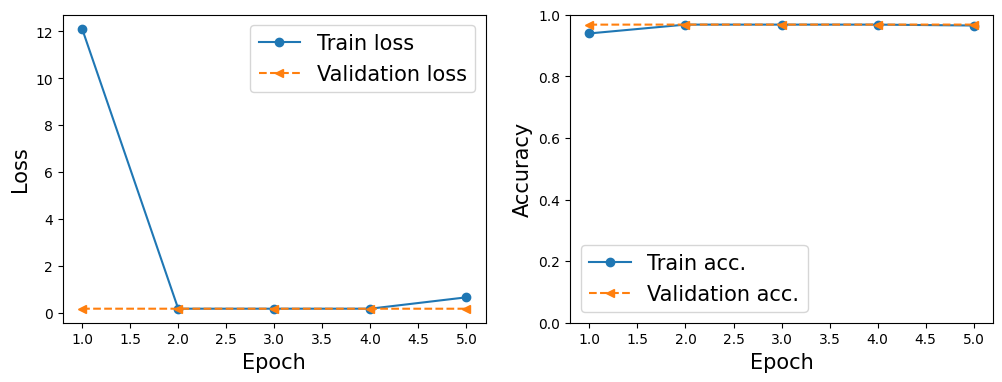

final train acc: 0.965
final val acc:   0.968

Percent Diff in Acc. -0.31%


In [59]:

class_model_1 = build_model_1(X_class_train.shape[1],y_class_train.shape[1])
# train model_tf on (X_train, y_train) data
history = class_model_1.fit(
    X_class_train,
    y_class_train,
    validation_data=(X_class_val,y_class_val),
    callbacks=[early_stopping],
    epochs=20)

# plot loss curves
show_history(history)


### Functional Model 1

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,628 (260.27 KB)

 Trainable params: 66,628 (260.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9518 - loss: 0.5844 - val_accuracy: 0.9680 - val_loss: 0.2366
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9653 - loss: 0.2117 - val_accuracy: 0.9680 - val_loss: 0.1692
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9656 - loss: 0.1898 - val_accuracy: 0.9680 - val_loss: 0.1751
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9655 - loss: 0.1767 - val_accuracy: 0.9666 - val_loss: 0.1710
Epoch 5/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9654 - loss: 0.1801 - val_accuracy: 0.9673 - val_loss: 0.1730
Epoch 6/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9659 - loss: 0.1801 - val_accuracy: 0.9680 - val_loss: 0.1670
Epoch 7/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9660 - loss: 0.1773 - val_accuracy: 0.9680 - val_loss: 0.1702
Epoch 8/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9656 - loss: 0.1852 - val_accurac

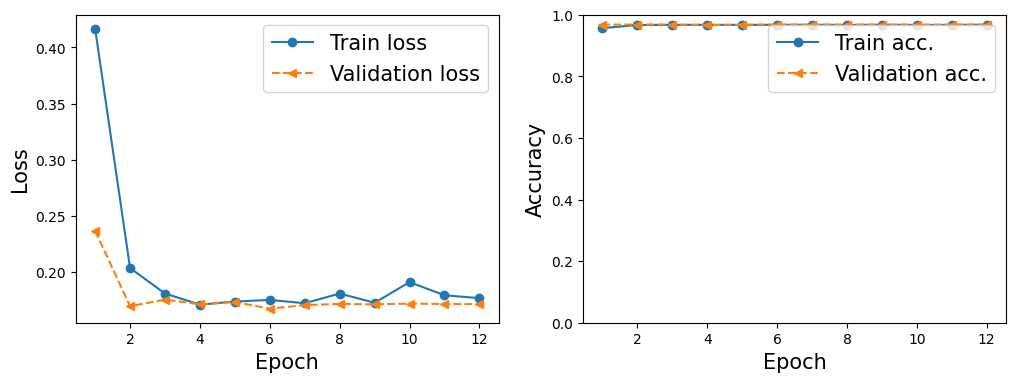

final train acc: 0.967
final val acc:   0.968

Percent Diff in Acc. -0.05%


In [60]:
class_model_1_func = build_functional_model_1(X_class_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_1_func.fit(
    X_class_train,
    y_class_train,
    validation_data=(X_class_val,y_class_val),
    callbacks=[early_stopping],
    epochs=20)

# plot loss curves
show_history(history)

### Model 2

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,508 (68.39 KB)

 Trainable params: 17,508 (68.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9537 - loss: 2.0342 - val_accuracy: 0.9680 - val_loss: 0.1715
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9664 - loss: 0.1802 - val_accuracy: 0.9680 - val_loss: 0.1713
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9666 - loss: 0.1781 - val_accuracy: 0.9680 - val_loss: 0.1712
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9666 - loss: 0.1781 - val_accuracy: 0.9680 - val_loss: 0.1712
Epoch 5/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9666 - loss: 0.1796 - val_accuracy: 0.9680 - val_loss: 0.1711
Epoch 6/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9665 - loss: 0.1793 - val_accuracy: 0.9680 - val_loss: 0.1711
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


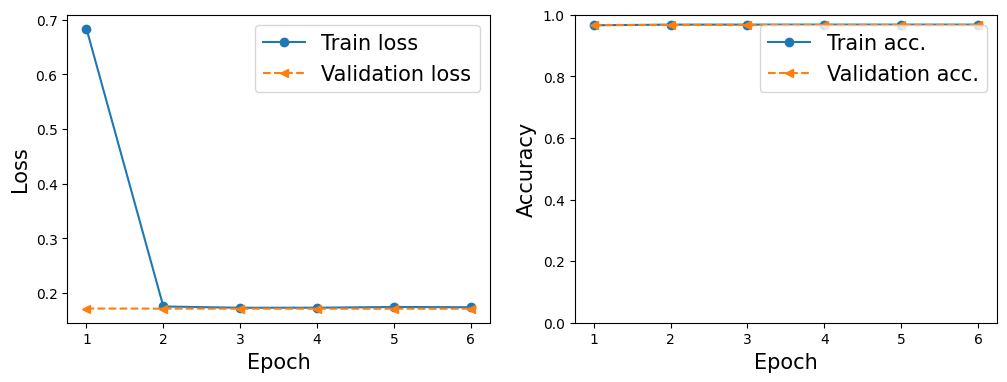

final train acc: 0.968
final val acc:   0.968

Percent Diff in Acc. -0.01%


In [22]:
class_model_2 = build_model_2(X_class_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_2.fit(
    X_class_train,
    y_class_train,
    validation_data=(X_class_val,y_class_val),
    callbacks=[early_stopping],
    epochs=20)

# plot loss curves
show_history(history)

#### Functional Model 2

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 8, 8, 32)       │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,940 (140.39 KB)

 Trainable params: 35,940 (140.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9556 - loss: 0.2953 - val_accuracy: 0.9680 - val_loss: 0.1762
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9665 - loss: 0.1883 - val_accuracy: 0.9680 - val_loss: 0.1707
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9665 - loss: 0.1776 - val_accuracy: 0.9680 - val_loss: 0.1710
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9666 - loss: 0.1767 - val_accuracy: 0.9680 - val_loss: 0.1710
Epoch 5/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9665 - loss: 0.1771 - val_accuracy: 0.9680 - val_loss: 0.1711
Epoch 6/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9666 - loss: 0.1766 - val_accuracy: 0.9680 - val_loss: 0.1712
Epoch 7/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9666 - loss: 0.1767 - val_accuracy: 0.9680 - val_loss: 0.1712
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


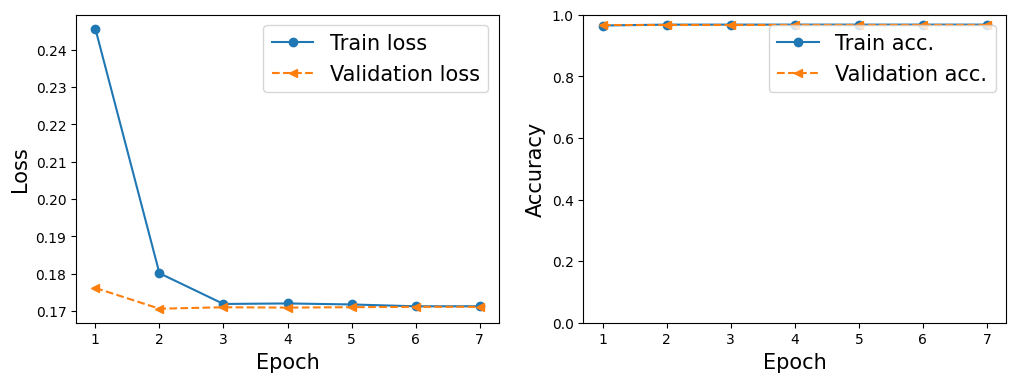

final train acc: 0.968
final val acc:   0.968

Percent Diff in Acc. -0.01%


In [61]:
class_model_2_func = build_functional_model_2(X_class_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_2_func.fit(
    X_class_train,
    y_class_train,
    validation_data=(X_class_val,y_class_val),
    callbacks=[early_stopping],
    epochs=20)

# plot loss curves
show_history(history)

### Model 3 Sequential

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 16)       │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,404 (48.45 KB)

 Trainable params: 12,404 (48.45 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9504 - loss: 1.9042 - val_accuracy: 0.9680 - val_loss: 0.1714
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9666 - loss: 0.1781 - val_accuracy: 0.9680 - val_loss: 0.1712
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9665 - loss: 0.1828 - val_accuracy: 0.9680 - val_loss: 0.1712
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9666 - loss: 0.1782 - val_accuracy: 0.9680 - val_loss: 0.1711
Epoch 5/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9666 - loss: 0.1782 - val_accuracy: 0.9680 - val_loss: 0.1711
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


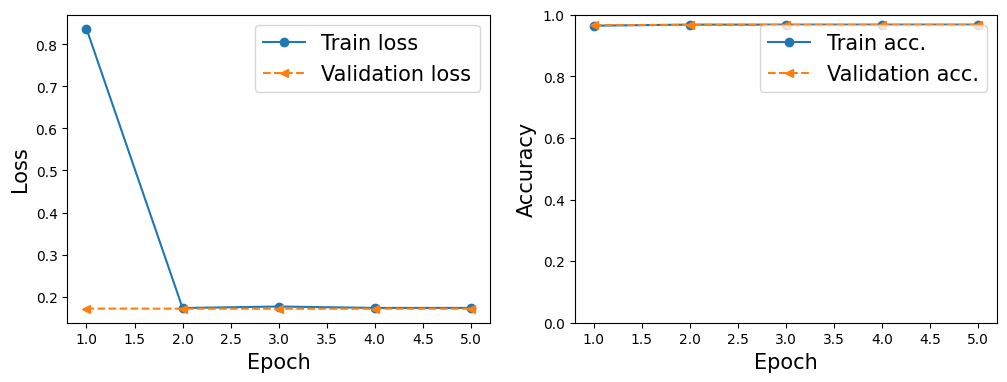

final train acc: 0.968
final val acc:   0.968

Percent Diff in Acc. -0.01%


In [24]:
class_model_3 = build_model_3(X_class_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_3.fit(
    X_class_train,
    y_class_train,
    validation_data=(X_class_val,y_class_val),
    callbacks=[early_stopping],
    epochs=20)

# plot loss curves
show_history(history)

#### Model 3 Functional

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 8, 8, 32)       │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 2, 2, 16)       │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,164 (164.70 KB)

 Trainable params: 42,164 (164.70 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9521 - loss: 0.3303 - val_accuracy: 0.9680 - val_loss: 0.1736
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9662 - loss: 0.1823 - val_accuracy: 0.9680 - val_loss: 0.1714
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9666 - loss: 0.1772 - val_accuracy: 0.9680 - val_loss: 0.1713
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9666 - loss: 0.1770 - val_accuracy: 0.9680 - val_loss: 0.1712
Epoch 5/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9666 - loss: 0.1768 - val_accuracy: 0.9680 - val_loss: 0.1713
Epoch 6/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9666 - loss: 0.1770 - val_accuracy: 0.9680 - val_loss: 0.1712
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


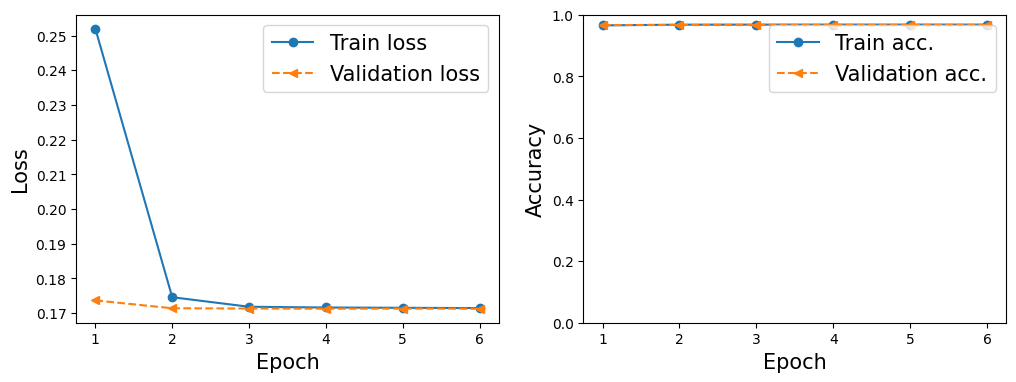

final train acc: 0.968
final val acc:   0.968

Percent Diff in Acc. -0.01%


In [62]:
class_model_3_func = build_functional_model_3(X_class_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_3_func.fit(
    X_class_train,
    y_class_train,
    validation_data=(X_class_val,y_class_val),
    callbacks=[early_stopping],
    epochs=20)

# plot loss curves
show_history(history)

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 128)    │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 16)       │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,348 (684.95 KB)

 Trainable params: 175,348 (684.95 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9531 - loss: 0.3012 - val_accuracy: 0.9680 - val_loss: 0.1715
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9666 - loss: 0.1835 - val_accuracy: 0.9680 - val_loss: 0.1714
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9666 - loss: 0.1802 - val_accuracy: 0.9680 - val_loss: 0.1723
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9666 - loss: 0.1801 - val_accuracy: 0.9680 - val_loss: 0.1710
Epoch 5/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9665 - loss: 0.1859 - val_accuracy: 0.9680 - val_loss: 0.1710
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


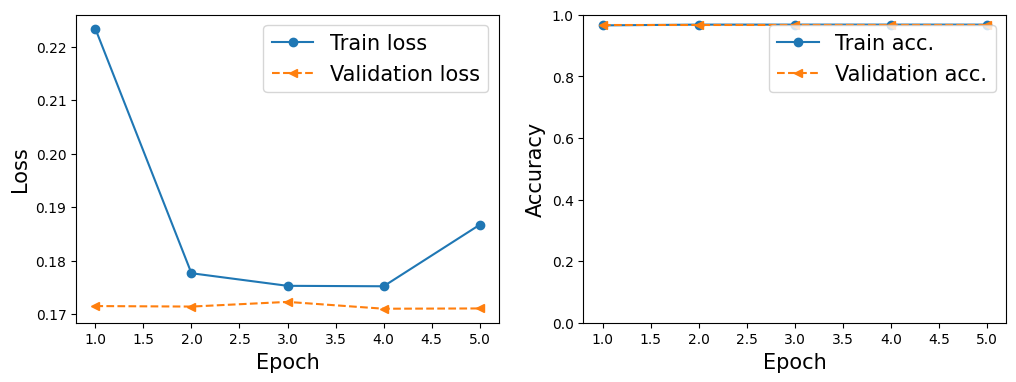

final train acc: 0.968
final val acc:   0.968

Percent Diff in Acc. -0.01%


In [63]:
class_model_4_func = build_functional_model_4(X_class_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_4_func.fit(
    X_class_train,
    y_class_train,
    validation_data=(X_class_val,y_class_val),
    callbacks=[early_stopping],
    epochs=20)

# plot loss curves
show_history(history)

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 256)    │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 128)    │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 32)       │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 4, 4, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,564 (2.77 MB)

 Trainable params: 726,564 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.9565 - loss: 0.6354 - val_accuracy: 0.9680 - val_loss: 0.1710
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9666 - loss: 0.1858 - val_accuracy: 0.9680 - val_loss: 0.1711
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9666 - loss: 0.1806 - val_accuracy: 0.9680 - val_loss: 0.1710
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9663 - loss: 0.2198 - val_accuracy: 0.9680 - val_loss: 0.1712
Epoch 5/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - accuracy: 0.9666 - loss: 0.1802 - val_accuracy: 0.9680 - val_loss: 0.1712
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


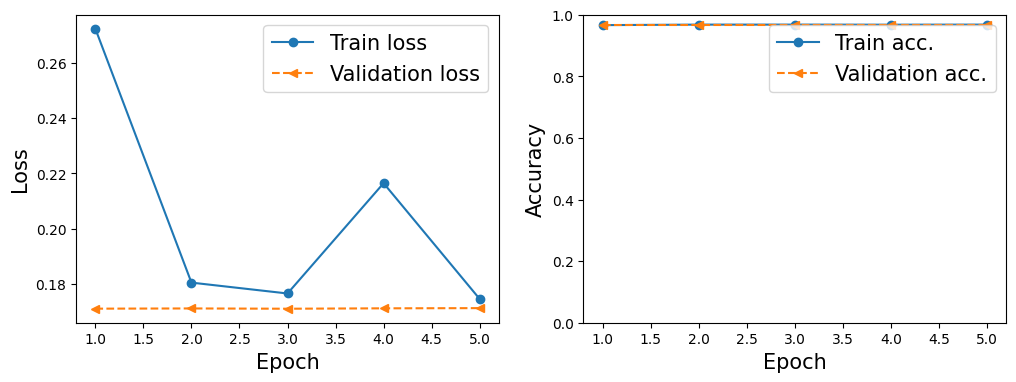

final train acc: 0.968
final val acc:   0.968

Percent Diff in Acc. -0.01%


In [64]:
class_model_5_func = build_functional_model_5(X_class_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_5_func.fit(
    X_class_train,
    y_class_train,
    validation_data=(X_class_val,y_class_val),
    callbacks=[early_stopping],
    epochs=20)

# plot loss curves
show_history(history)

### Data Augmentation

In [29]:
def add_augmentation(train_data, train_label, bright_delta, contrast_factor):
        print("Before augmentation: X shape:", train_data.shape)
        print("Before augmentation: y shape:", train_label.shape)
        # adjust brightness
        X_augm =  tf.image.adjust_brightness(train_data, bright_delta)
        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=contrast_factor)

        # concatenate original X and augmented X_aug data
        X = tf.concat([train_data, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = train_label
        y = tf.concat([train_label, y_augm],axis=0)
        print("After augmentation: X shape:", X.shape)
        print("After augmentation: y shape:", y.shape)
        return X, y


Before augmentation: X shape: (34276, 64, 64, 1)
Before augmentation: y shape: (34276, 4)
After augmentation: X shape: (68552, 64, 64, 1)
After augmentation: y shape: (68552, 4)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 128)    │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 16)       │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,348 (684.95 KB)

 Trainable params: 175,348 (684.95 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.9635 - loss: 0.2286 - val_accuracy: 0.9680 - val_loss: 0.1722
Epoch 2/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.9684 - loss: 0.1726 - val_accuracy: 0.9680 - val_loss: 0.1709
Epoch 3/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.9684 - loss: 0.1725 - val_accuracy: 0.9680 - val_loss: 0.1709
Epoch 4/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.9685 - loss: 0.1695 - val_accuracy: 0.9680 - val_loss: 0.1709
Epoch 5/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.9685 - loss: 0.1696 - val_accuracy: 0.9680 - val_loss: 0.1709
Epoch 6/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9685 - loss: 0.1695 - val_accuracy: 0.9680 - val_loss: 0.1709
Epoch 7/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.9684 - loss: 0.1724 - val_accuracy: 0.9680 - val_loss: 0.1709
Epoch 7: early stopping
Restoring model weights from the end of the bes

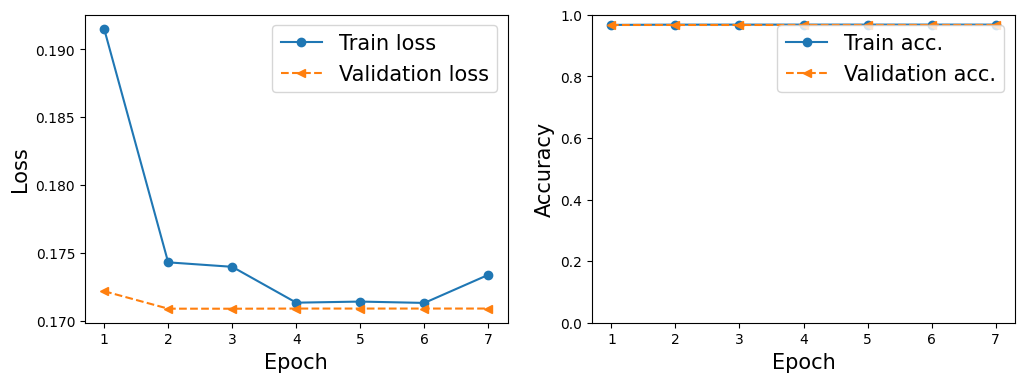

final train acc: 0.968
final val acc:   0.968

Percent Diff in Acc. -0.01%


In [31]:
#Add Data Augmentation
bright_delta = 0.4
contrast_factor = 0.4

X_class_train, y_class_train = add_augmentation(X_class_train, y_class_train, bright_delta,contrast_factor)

# Rerun Model 4 with augmented data

class_model_4_augm = build_functional_model_4(X_class_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_4_augm.fit(
    X_class_train,
    y_class_train,
    validation_data=(X_class_val,y_class_val),
    callbacks=[early_stopping],
    epochs=20)

# plot loss curves
show_history(history)

#### Model Evaluate

#### Model parmeter Hypertuning